In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import Hyperband
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping



In [2]:
# 🚀 GPU kontrol
print("📦 TensorFlow:", tf.__version__)
print("🧠 GPU:", tf.test.gpu_device_name())

📦 TensorFlow: 2.10.0
🧠 GPU: /device:GPU:0


In [3]:
# 📥 Veri yükleme
data = pd.read_csv("Merged_Data.csv", parse_dates=['Tarih'], index_col='Tarih', sep=',', decimal='.')
data = data.drop(columns=["Hacim", "Fark%", "GDP"], errors='ignore')
data.dropna(inplace=True)

In [4]:
# Özellik ve hedef
feature_names = ['AdjClose']
X_all = data[['AdjClose']].values
y_all = data[['AdjClose']].values


In [5]:
# Ölçekleme
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_all)
y_scaled = scaler_y.fit_transform(y_all)


In [6]:
# Sekans oluşturma
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X[i-window_size:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

In [7]:
window_size = 1
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)


In [8]:
# Eğitim/test böl
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]


In [9]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units_1', 32, 128, step=32), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units_2', 32, 128, step=32), return_sequences=False))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='mean_squared_error'
    )
    return model

In [10]:
# %%
# 🔍 Tuner başlat
tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='tuner_logs',
    project_name='lstm_base_adjclose'
)

# 🔄 Tuner eğitimi
tuner.search(X_train, y_train,
             epochs=50,
             batch_size=32,
             validation_data=(X_test, y_test),
             verbose=1)

# 🎯 En iyi hiperparametreleri al
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("🔧 En iyi hiperparametreler:")
for param in ['units_1', 'units_2', 'dropout_1', 'dropout_2', 'optimizer']:
    print(f"{param}: {best_hps.get(param)}")

# 🧠 Final modeli sıfırdan eğitiyoruz
final_model = Sequential()
final_model.add(LSTM(units=best_hps.get('units_1'), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
final_model.add(Dropout(best_hps.get('dropout_1')))
final_model.add(LSTM(units=best_hps.get('units_2'), return_sequences=False))
final_model.add(Dropout(best_hps.get('dropout_2')))
final_model.add(Dense(1))
final_model.compile(optimizer=best_hps.get('optimizer'), loss='mean_squared_error')

# 🛑 EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# 🚀 Eğitim
history = final_model.fit(X_train, y_train, epochs=50, batch_size=32,
                          validation_data=(X_test, y_test),
                          callbacks=[early_stop], verbose=1)


Trial 13 Complete [00h 00m 04s]
val_loss: 0.0005023622652515769

Best val_loss So Far: 0.00032790054683573544
Total elapsed time: 00h 01m 11s

Search: Running Trial #14

Hyperparameter    |Value             |Best Value So Far 
units_1           |96                |128               
dropout_1         |0.2               |0.4               
units_2           |64                |96                
dropout_2         |0.4               |0.3               
optimizer         |rmsprop           |adam              
tuner/epochs      |7                 |3                 
tuner/initial_e...|3                 |0                 
tuner/bracket     |2                 |2                 
tuner/round       |1                 |0                 
tuner/trial_id    |9a49aeacc752c63...|None              

Epoch 4/7
83/83 [==============================] - 3s 15ms/step - loss: 2.6938e-04 - val_loss: 0.1432
Epoch 5/7
83/83 [==============================] - 1s 8ms/step - loss: 7.5555e-05 - val_loss: 0.0031

FailedPreconditionError: tuner_logs\lstm_base_adjclose\trial_393b19652657419286e670cbe9af6ef5\checkpoints is not a directory

In [ ]:
# 📈 Tahmin
y_pred_scaled = final_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

21/21 [==============================] - 0s 3ms/step


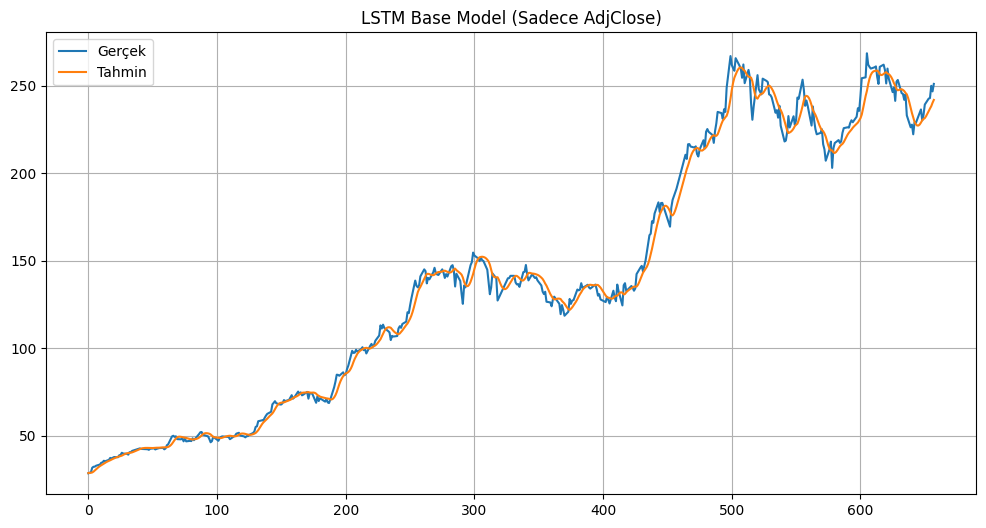

✅ RMSE: 5.694567411468302
📉 MAPE: 2.85%


In [ ]:
# 🖼️ Grafik
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Gerçek')
plt.plot(y_pred, label='Tahmin')
plt.title('LSTM Base Model (Sadece AdjClose)')
plt.legend()
plt.grid(True)
plt.show()

# 📊 Performans
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mape = np.mean(np.abs((y_test_inv - y_pred) / y_test_inv)) * 100
print("✅ RMSE:", rmse)
print("📉 MAPE: %.2f%%" % mape)

C:\Users\onugu\AppData\Local\Temp\ipykernel_28348\2154268338.py:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last6m = data.last('6M')
C:\Users\onugu\AppData\Local\Temp\ipykernel_28348\2154268338.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  last6m = data.last('6M')


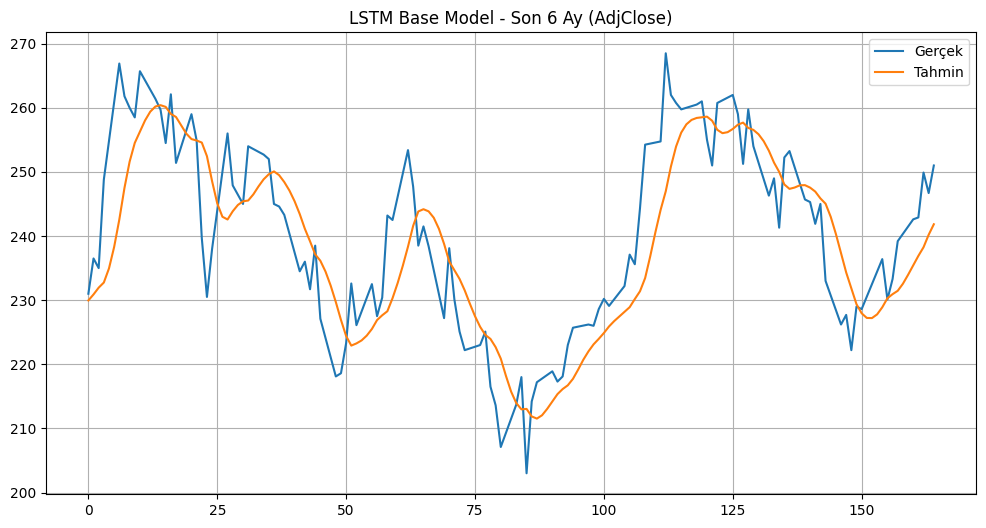

In [ ]:
# Zaman diziniyle son 6 ayı alalım (DataFrame üzerinde)
last6m = data.last('6M')

# Tahmin aralığını ona göre kısıtlayalım
# len(last6m) kadar son veri alınmalı
last_n = len(last6m)
y_test_last6m = y_test_inv[-last_n:]
y_pred_last6m = y_pred[-last_n:]

# Grafik
plt.figure(figsize=(12, 6))
plt.plot(y_test_last6m, label='Gerçek')
plt.plot(y_pred_last6m, label='Tahmin')
plt.title('LSTM Base Model - Son 6 Ay (AdjClose)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import copy
from sklearn.metrics import mean_squared_error



baseline_pred = final_model.predict(X_test)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

feature_importances = []

for i in range(X_test.shape[2]):  # özellik sayısı kadar dön
    X_test_copy = copy.deepcopy(X_test)
    np.random.shuffle(X_test_copy[:, :, i])  # sadece i. özelliği karıştır
    shuffled_pred = final_model.predict(X_test_copy)
    shuffled_rmse = np.sqrt(mean_squared_error(y_test, shuffled_pred))
    importance = shuffled_rmse - baseline_rmse
    feature_importances.append((feature_names[i], importance))

# Önem sırasına göre yazdır
feature_importances.sort(key=lambda x: x[1], reverse=True)
print("\n📊 Özellik Önem Sıralaması (Permutation Importance):")
for feat, imp in feature_importances:
    print(f"{feat}: Önem Skoru = {imp:.6f}")


21/21 [==============================] - 0s 3ms/step

📊 Özellik Önem Sıralaması (Permutation Importance):
AdjClose: Önem Skoru = 0.363390


In [ ]:
from log_record import log_model_report

model_name = "LSTM_base"
param_count = final_model.count_params()
feature_names = ['AdjClose']

log_model_report(
    model_name=model_name,
    window_size=window_size,
    feature_names=feature_names,
    units_1=best_hps.get('units_1'),
    units_2=best_hps.get('units_2'),
    dropout_1=best_hps.get('dropout_1'),
    dropout_2=best_hps.get('dropout_2'),
    optimizer=best_hps.get('optimizer'),
    param_count=param_count,
    rmse=rmse,
    mape=mape,
    feature_importances=feature_importances
)


📸 Grafik kaydedildi: plots/LSTM_base_result_2025-04-06_05-02-51.png


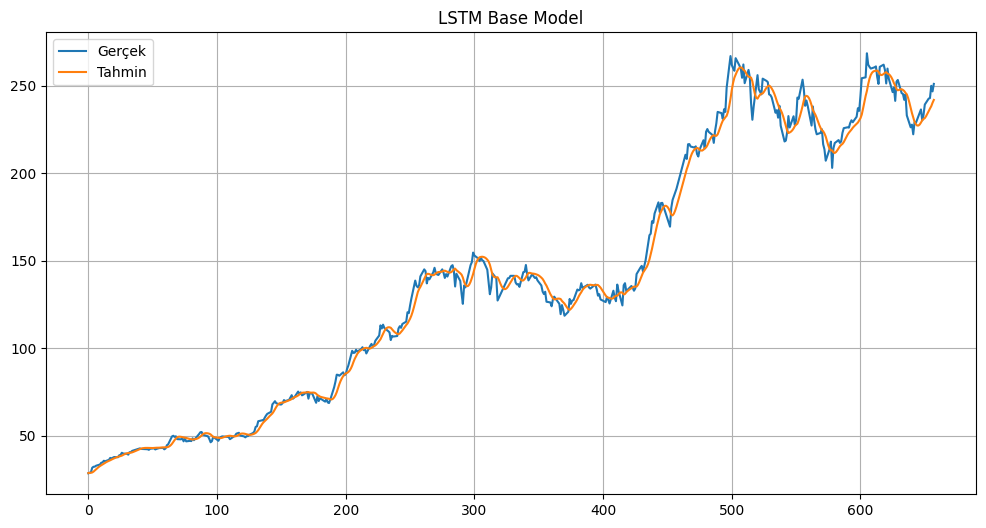

In [ ]:
from log_record import save_plot


plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Gerçek')
plt.plot(y_pred, label='Tahmin')
plt.title('LSTM Base Model')
plt.legend()
plt.grid(True)

save_plot("LSTM_base_result")  # sadece bunu çağır yeter
plt.show()


C:\Users\onugu\AppData\Local\Temp\ipykernel_28348\3420698958.py:3: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last6m = data.last('6M')
C:\Users\onugu\AppData\Local\Temp\ipykernel_28348\3420698958.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  last6m = data.last('6M')


📸 Grafik kaydedildi: plots/LSTM_base_result_2025-04-06_05-02-51.png


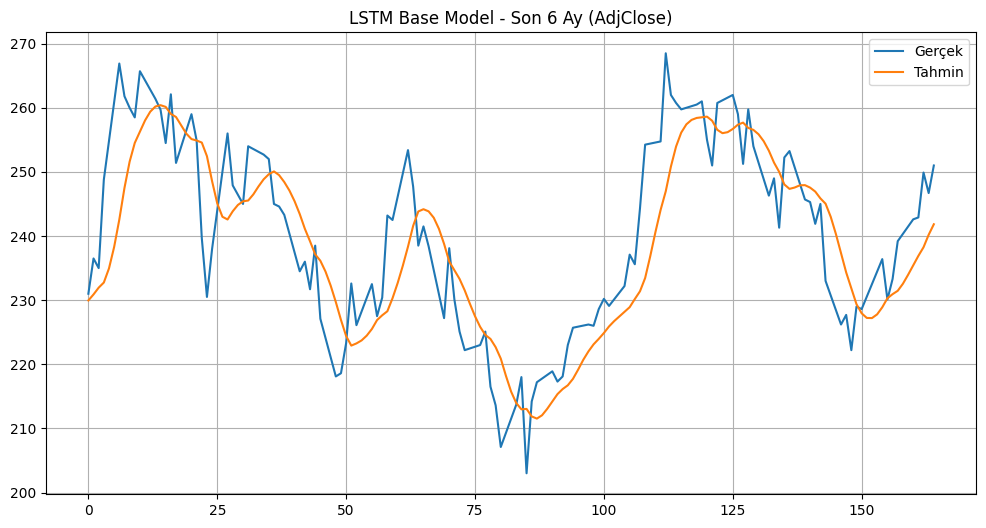

In [ ]:
# Zaman diziniyle son 6 ayı alalım (DataFrame üzerinde)
from log_record import save_plot
last6m = data.last('6M')

# Tahmin aralığını ona göre kısıtlayalım
# len(last6m) kadar son veri alınmalı
last_n = len(last6m)
y_test_last6m = y_test_inv[-last_n:]
y_pred_last6m = y_pred[-last_n:]

# Grafik
plt.figure(figsize=(12, 6))
plt.plot(y_test_last6m, label='Gerçek')
plt.plot(y_pred_last6m, label='Tahmin')
plt.title('LSTM Base Model - Son 6 Ay (AdjClose)')
plt.legend()
plt.grid(True)
save_plot("LSTM_base_result") 
plt.show()